## Startup Investment Trend Analyzer

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("indian_startup_funding.csv")
print(df.head())

         Date Startup Name              Industry               Sub-vertical  \
0  2021-04-14       Swiggy  Online Food Delivery       Online Food Delivery   
1  2021-04-14      Beldara            E-commerce     Global B2B marketplace   
2  2021-04-07        Groww               FinTech        Investment platform   
3  2021-04-05       Meesho            E-commerce  Online reselling platform   
4  2021-04-01       BYJU’S              Edu-tech            Online tutoring   

    Location                                          Investors  \
0  Bengaluru  Amansa Holdings, Carmignac, Falcon Edge Capita...   
1     Mumbai                           Hindustan Media Ventures   
2  Bengaluru         MC Global Edtech, B Capital, Baron, others   
3  Bengaluru                             SoftBank Vision Fund 2   
4  Bengaluru                                    Innoven Capital   

  Investment Type  Amount in USD              Website URL  
0        Series J    343000000.0  https://www.swiggy.com/  
1 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             3210 non-null   object 
 1   Startup Name     3212 non-null   object 
 2   Industry         2276 non-null   object 
 3   Sub-vertical     3041 non-null   object 
 4   Location         3032 non-null   object 
 5   Investors        3177 non-null   object 
 6   Investment Type  3205 non-null   object 
 7   Amount in USD    2222 non-null   float64
 8   Website URL      2670 non-null   object 
dtypes: float64(1), object(8)
memory usage: 226.0+ KB


## Cleaning the data

In [3]:
# Select relevant columns & rename for clarity
df = df[['Date', 'Startup Name', 'Industry', 'Location', 'Investment Type', 'Amount in USD']]
df=df.rename(columns={'Date':'date','Startup Name': 'startup_name', 'Industry':'industry','Location': 'location','Investment Type': 'investment_type', 'Amount in USD':'funding_amount'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             3210 non-null   object 
 1   startup_name     3212 non-null   object 
 2   industry         2276 non-null   object 
 3   location         3032 non-null   object 
 4   investment_type  3205 non-null   object 
 5   funding_amount   2222 non-null   float64
dtypes: float64(1), object(5)
memory usage: 150.7+ KB


In [5]:
# Clean funding_amount, convert to numeric (remove commas and missing data)
df['funding_amount'] = df['funding_amount'].astype(str).str.replace(',', '').str.strip()
df['funding_amount'] = pd.to_numeric(df['funding_amount'], errors='coerce')

In [6]:
df['funding_amount'].isnull().sum()

np.int64(990)

In [70]:
# Parse date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# median
median=df['funding_amount'].median()
df['funding_amount'].fillna(median,inplace=True)

In [9]:
# Drop rows with missing key info
df.dropna(subset=['date', 'funding_amount', 'industry', 'location','investment_type'], inplace=True)

# Create year column
df['year'] = df['date'].dt.year
df.head()

,date,startup_name,industry,location,investment_type,funding_amount,year
0,2021-04-14,Swiggy,Online Food Delivery,Bengaluru,Series J,343000000.0,2021
1,2021-04-14,Beldara,E-commerce,Mumbai,Venture,7400000.0,2021
2,2021-04-07,Groww,FinTech,Bengaluru,Series D,83000000.0,2021
3,2021-04-05,Meesho,E-commerce,Bengaluru,Series E,300000000.0,2021
4,2021-04-01,BYJU’S,Edu-tech,Bengaluru,Series F,460000000.0,2021


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2263 entries, 0 to 2275
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2263 non-null   datetime64[ns]
 1   startup_name     2263 non-null   object        
 2   industry         2263 non-null   object        
 3   location         2263 non-null   object        
 4   investment_type  2263 non-null   object        
 5   funding_amount   2263 non-null   float64       
 6   year             2263 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 132.6+ KB


## Store Raw Data in MongoDB

In [11]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['startup_analysis']
collection = db['funding_data']

collection.delete_many({})
collection.insert_many(df.to_dict('records'))
print("Inserted data into MongoDB")

Inserted data into MongoDB


## Query MongoDB for Funding Trends

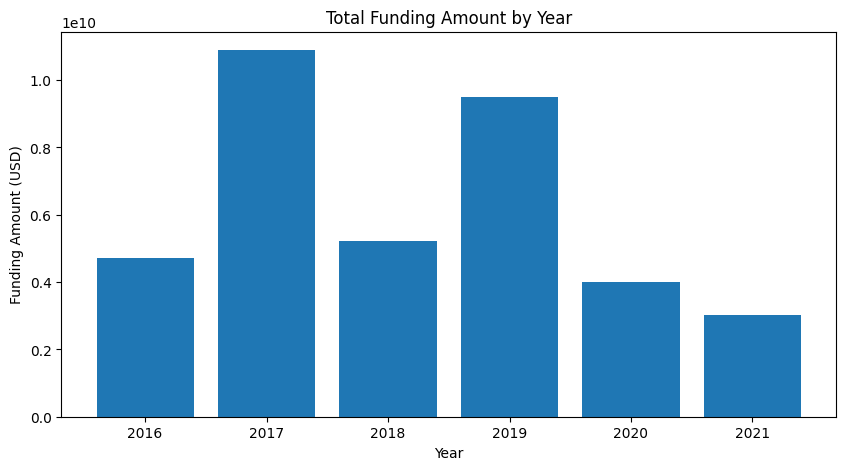

In [12]:
pipeline = [
    {
        "$group": {
            "_id": "$year",
            "total_funding": {"$sum": "$funding_amount"}
        }
    },
    {"$sort": {"_id": 1}}
]
results = list(collection.aggregate(pipeline))
years = [res['_id'] for res in results]
totals = [res['total_funding'] for res in results]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(years, totals)
plt.title("Total Funding Amount by Year")
plt.xlabel("Year")
plt.ylabel("Funding Amount (USD)")
plt.show()

## EDA - Top Funded Industries & Locations

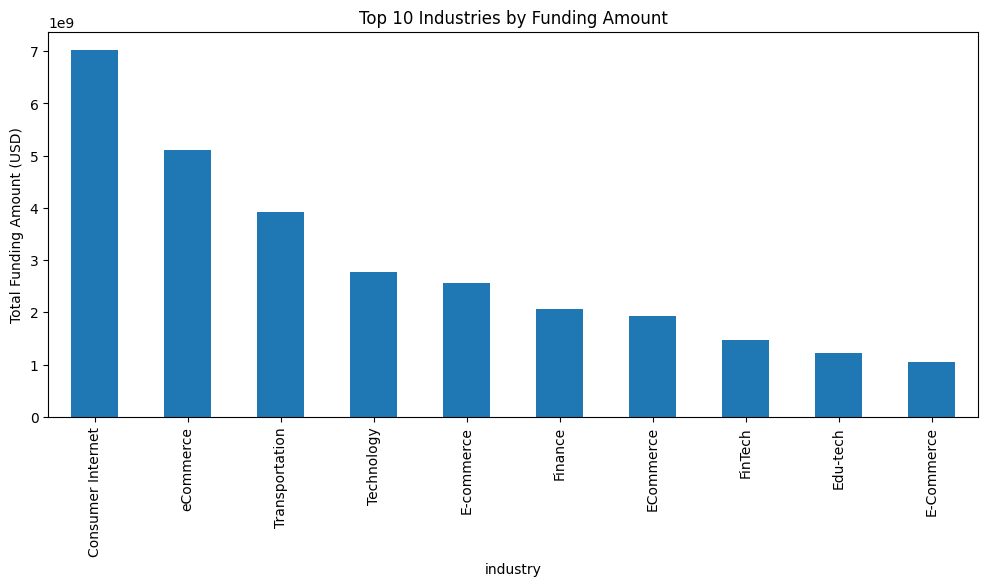

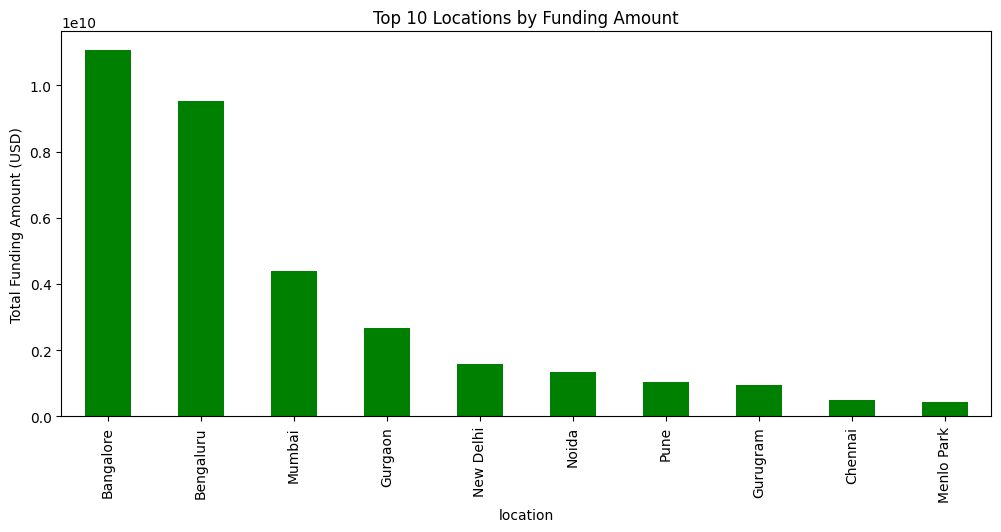

In [13]:
# EDA (Exploratory Data Analysis)

top_industries = df.groupby('industry')['funding_amount'].sum().sort_values(ascending=False).head(10)
top_locations = df.groupby('location')['funding_amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
top_industries.plot(kind='bar')
plt.title('Top 10 Industries by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

plt.figure(figsize=(12,5))
top_locations.plot(kind='bar', color='green')
plt.title('Top 10 Locations by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

In [15]:
df.describe()

,date,funding_amount,year
count,2263,2.263000e+03,2263.000000
mean,2017-06-12 19:10:28.369421312,1.651503e+07,2016.990720
min,2016-01-01 00:00:00,1.800000e+04,2016.000000
25%,2016-07-11 12:00:00,1.000000e+06,2016.000000
50%,2017-02-28 00:00:00,2.000000e+06,2017.000000
75%,2017-12-23 12:00:00,5.000000e+06,2017.000000
max,2021-04-14 00:00:00,3.900000e+09,2021.000000
std,NaN,1.176134e+08,1.202489


## Selecting Features and training the model

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [17]:
# selecting feature and target
features = df[['industry', 'location', 'investment_type']].copy()
target = df['funding_amount']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [20]:
categorical_features = ['industry', 'location', 'investment_type']
preprocessor = ColumnTransformer( transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [71]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## saving the model

In [72]:
import numpy as np
from joblib import dump, load

In [73]:
dump(best_model, 'startup_pred.joblib')
print("Model saved to 'startup_pred.joblib'")

Model saved to 'startup_pred.joblib'


## Testing the model on test data

In [74]:
from joblib import dump,load
model=load('startup_pred.joblib')

In [75]:
import pandas as pd

# Example input to predict
input = pd.DataFrame({
    'industry': ['Technology'],
    'location': ['New Delhi'],
    'investment_type': ['Seed Funding']
    # 'funding_round': ['Seed'],
    # 'startup_age': [7]
})
model.predict(input)[0]

np.float64(1223245.9742037796)